In [1]:

%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler



In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:26: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
#windows_d = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 10
holding_period = 3
cross = False
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [5]:
X_train, X_eval, X_test_full, y_train, y_eval, y_test_full, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# Initialize the portfolios
all_portfolios = {
    'lgb': pd.DataFrame(),
    'ridge': pd.DataFrame(),
    'NN': pd.DataFrame(),
    'benchmark': pd.DataFrame(),
}

# Initialize model storage dictionary
model_storage = {
    'lgb': {},
    'ridge': {},
    'NN': {},
    'benchmark': {},
}

df_2_read_storage = {}
signals_dfs_storage = {}
portfolio_dfs_storage = {}
X_test_storage = {}


# Initial training and testing periods
end_train_date = df.loc[X_eval.index.max(), 'todate']
end_test_date = df.loc[X_eval.index.max(), 'todate'] + pd.DateOffset(years=holding_period)
start_train_idx = df.index.min()
end_train_idx = X_eval.index.max()

if end_test_date not in df[date_col]:
    end_test_idx = df.index[df[date_col] <= end_test_date].max()
else:
    end_test_idx = df.index.get_loc(end_test_date)

end_test_date_set_to_max = False

print(f"Initial training period: {start_train_idx} to {end_train_idx}")
print(f"Initial testing period: {end_train_idx + 1} to {end_test_idx}")


# Define model parameters and training functions here

while pd.to_datetime(end_test_date) <= df['todate'].max():
    # Slice the training and test datasets based on the dates
    X_test = X_test_full.loc[end_train_idx + 1:end_test_idx]
    y_test = y_test_full.loc[end_train_idx + 1:end_test_idx]
    print(f"New training period: {start_train_idx} to {end_train_idx}")

    # Check if X_test and y_test are not empty
    if X_test.empty or y_test.empty:
        break

    # Define model parameters
    param_grid_NN = {
        'optimizer': ['adam', 'rmsprop'],
        'epochs': [50],
        'batch_size': [64]
    }

    NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)

    param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}

    ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_eval, y_eval, param_grid_alpha, cross)

    param_grid_lgb = {
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127, 255]
    }

    lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)

    # Store models in the dictionary
    model_storage['lgb'][end_train_date] = lgb_best
    model_storage['ridge'][end_train_date] = ridge_best
    model_storage['NN'][end_train_date] = NN_model
    model_storage['benchmark'][end_train_date] = None
    # Store df_2_read and associated data
    df_2 = df.loc[X_test.index]
    df_2_read = df_read.loc[df_2[date_col].unique()]
    df_2_read.fillna(0, inplace=True)
    df_2_read_storage[end_train_date] = df_2_read

    df_2_neutral = df_2_read.copy()
    df_2_neutral.loc[:, :] = 0

    signals_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    portfolio_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }
    X_test_storage[end_train_date] = X_test

    end_train_date = end_test_date
    end_test_date = pd.to_datetime(end_test_date) + pd.DateOffset(years=holding_period)
    if pd.to_datetime(end_test_date) > df['todate'].max():
        if not end_test_date_set_to_max:
            print("Reached the end of available data in first iteration.")
            end_test_date = df['todate'].max()
            end_test_date_set_to_max = True
            if end_test_date not in df[date_col]:
                end_test_idx = df.index[df[date_col] <= end_test_date].max()
            else:
                end_test_idx = df.index.get_loc(end_test_date)
            print(f"Updated end_test_idx to last date: {end_test_idx}")  
        else:
            print("Reached the end of available data.")
            break

    

    X_combined = pd.concat([X_train, X_eval, X_test])
    y_combined = pd.concat([y_train, y_eval, y_test])

    split_idx = len(X_combined) // 2

    # Update X_train and X_eval with the first and second halves of the combined data
    X_train = X_combined.iloc[:split_idx]
    X_eval = X_combined.iloc[split_idx:]

    # Update y_train and y_eval similarly
    y_train = y_combined.iloc[:split_idx]
    y_eval = y_combined.iloc[split_idx:]

    # Update start and end indices
    start_train_idx = X_train.index.min()
    end_train_idx = X_eval.index.max()
    if end_test_date not in df[date_col]:
        end_test_idx = df.index[df[date_col] <= end_test_date].max()
    else:
        end_test_idx = df.index.get_loc(end_test_date)



Initial training period: 120225 to 319039
Initial testing period: 319040 to 364402
New training period: 120225 to 319039


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1522/1522 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.5649 - loss: 0.2445 - val_accuracy: 0.6032 - val_loss: 0.2370
Epoch 2/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.5848 - loss: 0.2394 - val_accuracy: 0.5846 - val_loss: 0.2408
Epoch 3/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.5925 - loss: 0.2374 - val_accuracy: 0.5968 - val_loss: 0.2394
Epoch 4/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.6003 - loss: 0.2352 - val_accuracy: 0.5887 - val_loss: 0.2425
Epoch 5/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.6069 - loss: 0.2332 - val_accuracy: 0.5821 - val_loss: 0.2443
Epoch 6/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.6118 - loss: 0.2310 - val_accuracy: 0.5624 - val_loss: 0.2497
Epoch 7/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.6197 - loss: 0.2297 - val_accuracy: 0.5491 - val_loss: 0.2546
Epoch 8/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.6215 - loss: 0.22

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1871/1871 ━━━━━━━━━━━━━━━━━━━━ 3s 956us/step - accuracy: 0.5668 - loss: 0.2437 - val_accuracy: 0.5862 - val_loss: 0.2388
Epoch 2/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.5883 - loss: 0.2386 - val_accuracy: 0.5979 - val_loss: 0.2384
Epoch 3/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.5910 - loss: 0.2369 - val_accuracy: 0.5957 - val_loss: 0.2394
Epoch 4/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.5989 - loss: 0.2354 - val_accuracy: 0.5843 - val_loss: 0.2408
Epoch 5/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.6027 - loss: 0.2337 - val_accuracy: 0.5785 - val_loss: 0.2410
Epoch 6/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - accuracy: 0.6075 - loss: 0.2325 - val_accuracy: 0.5805 - val_loss: 0.2416
Epoch 7/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step - accuracy: 0.6139 - loss: 0.2307 - val_accuracy: 0.5802 - val_loss: 0.2424
Epoch 8/50
1871/1871 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.6173 - loss: 0.22

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 65632, number of negative: 54098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 119730, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548167 -> initscore=0.193266
[LightGBM] [Info] Start training from score 0.193266
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Info] Number of positive: 132524, number of negative: 106937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 239461, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2221/2221 ━━━━━━━━━━━━━━━━━━━━ 3s 945us/step - accuracy: 0.5672 - loss: 0.2433 - val_accuracy: 0.5930 - val_loss: 0.2385
Epoch 2/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.5880 - loss: 0.2389 - val_accuracy: 0.5969 - val_loss: 0.2378
Epoch 3/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.5943 - loss: 0.2368 - val_accuracy: 0.5897 - val_loss: 0.2394
Epoch 4/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - accuracy: 0.5990 - loss: 0.2358 - val_accuracy: 0.5878 - val_loss: 0.2403
Epoch 5/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - accuracy: 0.6054 - loss: 0.2338 - val_accuracy: 0.5836 - val_loss: 0.2412
Epoch 6/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - accuracy: 0.6012 - loss: 0.2342 - val_accuracy: 0.5796 - val_loss: 0.2431
Epoch 7/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - accuracy: 0.6081 - loss: 0.2327 - val_accuracy: 0.5874 - val_loss: 0.2425
Epoch 8/50
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.6110 - loss: 0.23

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2569/2569 ━━━━━━━━━━━━━━━━━━━━ 3s 924us/step - accuracy: 0.5748 - loss: 0.2427 - val_accuracy: 0.5946 - val_loss: 0.2379
Epoch 2/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 879us/step - accuracy: 0.5902 - loss: 0.2389 - val_accuracy: 0.5920 - val_loss: 0.2389
Epoch 3/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - accuracy: 0.5964 - loss: 0.2372 - val_accuracy: 0.5888 - val_loss: 0.2393
Epoch 4/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 875us/step - accuracy: 0.5988 - loss: 0.2365 - val_accuracy: 0.5943 - val_loss: 0.2400
Epoch 5/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 875us/step - accuracy: 0.6050 - loss: 0.2351 - val_accuracy: 0.5844 - val_loss: 0.2415
Epoch 6/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 875us/step - accuracy: 0.6058 - loss: 0.2341 - val_accuracy: 0.5839 - val_loss: 0.2426
Epoch 7/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.6109 - loss: 0.2331 - val_accuracy: 0.5838 - val_loss: 0.2424
Epoch 8/50
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 888us/step - accuracy: 0.6141 - loss: 0.23

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 89665, number of negative: 74742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 164407, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545384 -> initscore=0.182038
[LightGBM] [Info] Start training from score 0.182038
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Info] Number of positive: 182478, number of negative: 146337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 328815, number 

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step - accuracy: 0.5810 - loss: 0.2417 - val_accuracy: 0.5980 - val_loss: 0.2370
Epoch 2/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step - accuracy: 0.5943 - loss: 0.2379 - val_accuracy: 0.5937 - val_loss: 0.2384
Epoch 3/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 866us/step - accuracy: 0.5990 - loss: 0.2364 - val_accuracy: 0.5927 - val_loss: 0.2391
Epoch 4/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 883us/step - accuracy: 0.6027 - loss: 0.2352 - val_accuracy: 0.5873 - val_loss: 0.2396
Epoch 5/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 868us/step - accuracy: 0.6050 - loss: 0.2346 - val_accuracy: 0.5895 - val_loss: 0.2392
Epoch 6/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 875us/step - accuracy: 0.6075 - loss: 0.2333 - val_accuracy: 0.5837 - val_loss: 0.2406
Epoch 7/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 875us/step - accuracy: 0.6114 - loss: 0.2328 - val_accuracy: 0.5825 - val_loss: 0.2415
Epoch 8/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 876us/step - accuracy: 0.6138 - loss: 0.23

In [25]:
for name, model_dict in model_storage.items():
    """if name == 'benchmark':
        print(f"Training and testing {name} model for the entire period")
        X_test = X_test_full
        last_train_date = list(signals_dfs_storage.keys())[-1]
        signals_dfs = signals_dfs_storage[last_train_date]
        portfolio_dfs = portfolio_dfs_storage[last_train_date]

        for _, model in model_dict.items():
            best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30)
            assets_df = pd.concat([best_assets, worst_assets])
            assets_df['update_value'] = 0
            assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
            assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

            pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
            signals_dfs[name].update(pivot_df)

            portfolio_dfs[name] = update_df_with_asset_performance(
                signals_dfs[name], 
                portfolio_dfs[name], 
                target_days, 
                df_read
            )
            all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name]])
    else:"""
    for train_date, model in model_dict.items():
        X_test = X_test_storage[train_date]
        df_2_read = df_2_read_storage[train_date]

        signals_dfs = signals_dfs_storage[train_date]
        portfolio_dfs = portfolio_dfs_storage[train_date]
        print(f"Training and testing {name} models for {train_date}")
        best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=80, bottom_percentile=20)
    
        assets_df = pd.concat([best_assets, worst_assets])
        assets_df['update_value'] = 0
        assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
        assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

        pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
        signals_dfs[name].update(pivot_df)

        portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)
        all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name]])
                

Training and testing lgb models for 2011-01-05 00:00:00
Training and testing lgb models for 2014-01-05 00:00:00
Training and testing lgb models for 2017-01-05 00:00:00
Training and testing lgb models for 2020-01-05 00:00:00
Training and testing lgb models for 2023-01-05 00:00:00
Training and testing ridge models for 2011-01-05 00:00:00
Training and testing ridge models for 2014-01-05 00:00:00
Training and testing ridge models for 2017-01-05 00:00:00
Training and testing ridge models for 2020-01-05 00:00:00
Training and testing ridge models for 2023-01-05 00:00:00
Training and testing NN models for 2011-01-05 00:00:00
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
Training and testing NN models for 2014-01-05 00:00:00
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
Training and testing NN models for 2017-01-05 00:00:00
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step
Training and testing NN models for 2020-01-05 00:00:00
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step
Training and testing NN models

In [26]:
# Store predictions in a dictionary
"""predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")
"""

'predictions = {\n    "Ridge Classifier": ridge_best.predict(X_test),\n    "LightGBM Classifier": lgb_best.predict(X_test),\n    "Neural Network": NN_model.predict(X_test_scaled)\n}   \n\n# Iterate through the dictionary and evaluate each model\nfor model_name, y_pred in predictions.items():\n    print(model_name + ":")\n    if model_name == "Neural Network":\n        y_pred = (y_pred > 0.5).astype(int)\n    evaluate_model_performance(y_test, y_pred)\n    print("\n")\n'

In [27]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test_full.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)

In [28]:
lgb_weights = all_portfolios['lgb']
ridge_weights = all_portfolios['ridge']
NN_weights = all_portfolios['NN']
benchmark_weights = all_portfolios['benchmark']




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read


"""
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)"""

'\nlgb_trade_volume = calculate_trade_volume(lgb_weights)\nridge_trade_volume = calculate_trade_volume(ridge_weights)\nNN_trade_volume = calculate_trade_volume(NN_weights)'

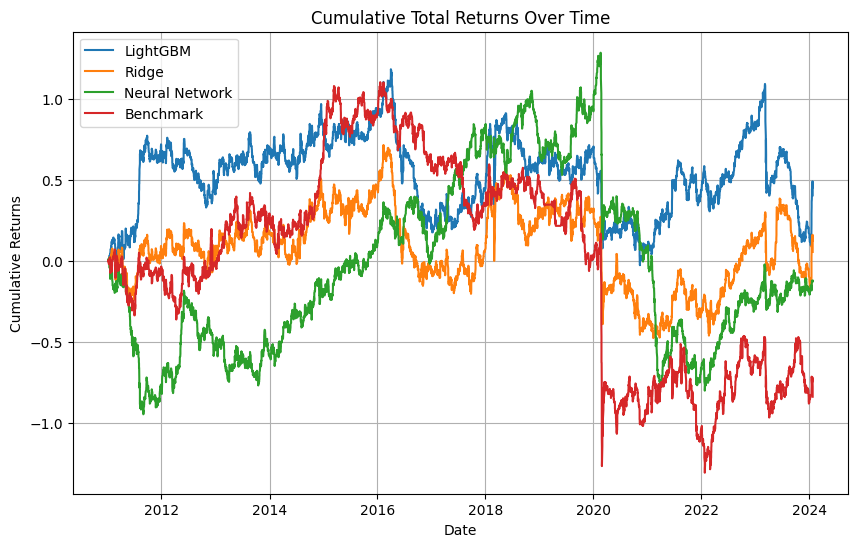

In [29]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [30]:
%reload_ext autoreload
%autoreload 2
ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [31]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Yearly Sharpe Ratio,Max Drawdown,Yearly Volatility,Calmar Ratio,Skewness,Kurtosis,Yearly Trades,Yearly Turnover,Yearly Transaction Costs
Ridge,0.001328,0.133336,0.009961,-0.696511,0.133336,0.001907,-0.316441,7.518615,3307.857143,541.029873,0.054103
LightGBM,0.010074,0.141058,0.071415,-0.701749,0.141058,0.014355,-0.998582,22.634478,3286.857143,699.722750,0.069972
Neural Network,-0.003116,0.131116,-0.023766,-0.875877,0.131116,-0.003558,-1.580905,18.234742,3290.357143,818.174445,0.081817
Benchmark,-0.021039,0.148625,-0.141555,-0.910316,0.148625,-0.023111,-1.884637,41.989535,888.214286,152.322623,0.015232


In [32]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



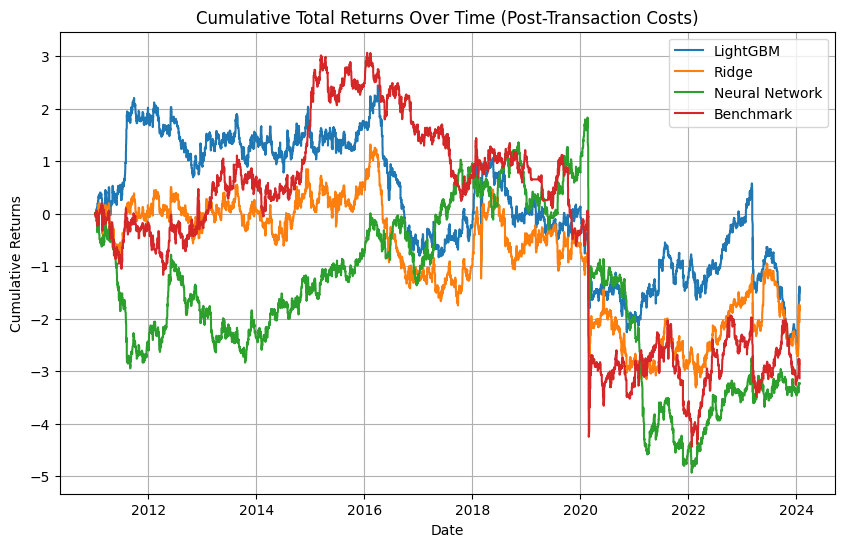

In [33]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

